# PART 2. Time Series Analysis

### 2.1 Calculate Produced Energy and Capacity Factor
In this part we calculate three quantities to be analysed as a funciton of the time:

- The **Average Energy** can be calculated from the average Active Power (P_avg, in kW)
- The **Produced Energy** is the integral over time of the average energy
- The **Capacity Factor** is the ratio of the real power output and nominal rated power

### 2.2 Test several Auto-Regression analysis
- Auto-Regression
- ARIMA - AutoRegression Integrated Moving Average

In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autotime

time: 348 µs (started: 2024-04-11 16:27:47 +02:00)


In [2]:
from windml.core.functions import load_all
data_dir = Path.cwd().parent.parent / 'Data Turbines - enriched'
df = load_all(data_dir)

Loading time: 6.11 seconds.
Memory usage: 270.29 MB.
1045835 Lines found.
time: 17.1 s (started: 2024-04-11 16:27:47 +02:00)


In [3]:
df['E_avg'] = df['P_avg'] / 6000 # from kW to MWh

P_nom = 2050 # kW | nominal power
df['CF_avg'] = df['P_avg'] / P_nom 

monthly_df = pd.DataFrame(df.groupby(['Year', 'Month'])[['P_avg', 'E_avg', 'CF_avg']].apply(lambda x : x.sum()))
monthly_df.reset_index(inplace=True)

time: 245 ms (started: 2024-04-11 16:28:04 +02:00)


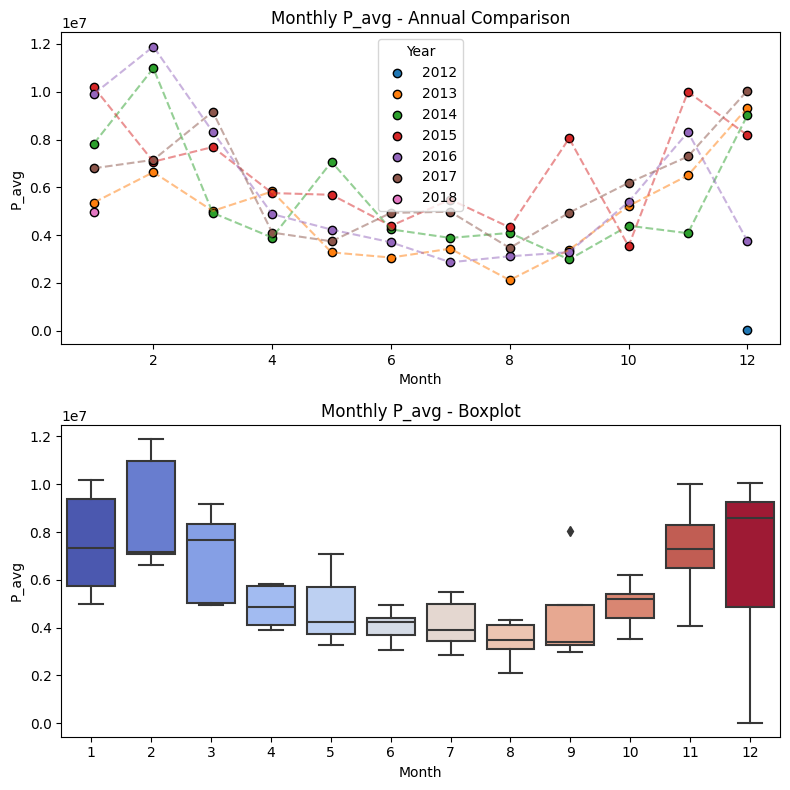

time: 1.07 s (started: 2024-04-11 16:50:34 +02:00)


In [28]:
from windml.visualization import custom_plots

custom_plots.plot_monthly_evolution(monthly_df, value_col='P_avg')
#custom_plots.plot_monthly_evolution(monthly_df, value_col='E_avg')
#custom_plots.plot_monthly_evolution(monthly_df, value_col='CF_avg')


### Auto-Regression Algorithm

Mean Absolute Error (MAE): 291.06713290889434
Mean Absolute Error (MAE): 267.38034867764384
Mean Absolute Error (MAE): 275.8761545081877
Mean Absolute Error (MAE): 312.90733468234737


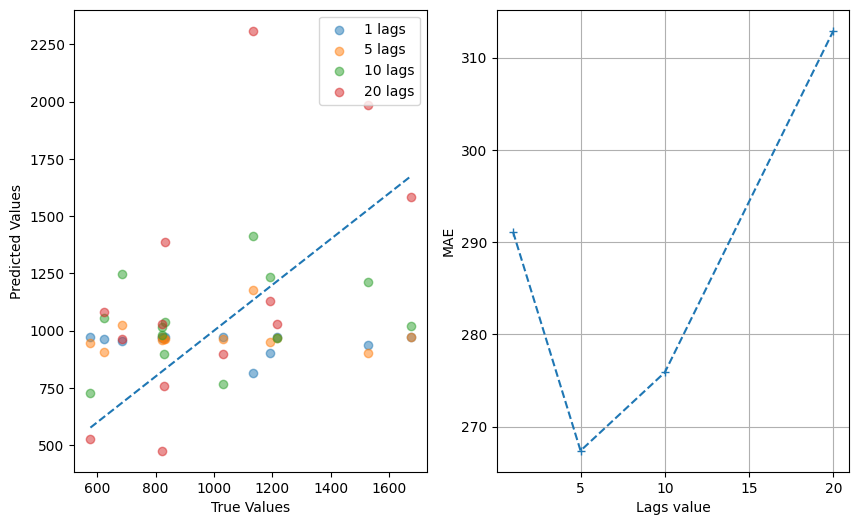

time: 566 ms (started: 2024-04-11 16:39:34 +02:00)


In [22]:
import numpy as np
from windml.machine_learning.time_analysis import ar_forecast
from sklearn.metrics import mean_absolute_error

fig, ax = plt.subplots(1, 2, figsize=(10, 6))

mae_list = []
lags_list = [1, 5, 10, 20]

for lags in lags_list:
    
    forecast_df = ar_forecast(monthly_df, 'E_avg', lags=lags)
    merged_df = pd.merge(monthly_df, forecast_df, on=['Year', 'Month'], how='inner')
    
    mae = mean_absolute_error(merged_df['E_avg'], merged_df['pred_E_avg'])
    mae_list.append(mae)
    ax[0].scatter(merged_df['E_avg'], merged_df['pred_E_avg'], alpha=0.5, label=f'{lags} lags')
    print(f"Mean Absolute Error (MAE): {mae}")

ax[0].set_xlabel('True Values')
ax[0].set_ylabel('Predicted Values')
ax[0].legend()

xx = np.linspace(merged_df['E_avg'].min(),merged_df['E_avg'].max())
ax[0].plot(xx, xx, ls='--')

ax[1].plot(lags_list, mae_list, '+', ls = '--')
ax[1].set_xlabel('Lags value')
ax[1].set_ylabel('MAE')

plt.grid(True)
plt.show()


### Auto-Regression Integrated Moving Average Algorithm

Mean Absolute Error (MAE): 312.90733468234737
Mean Absolute Error (MAE): 312.90733468234737
Mean Absolute Error (MAE): 312.90733468234737
Mean Absolute Error (MAE): 312.90733468234737
Mean Absolute Error (MAE): 312.90733468234737
Mean Absolute Error (MAE): 312.90733468234737
Mean Absolute Error (MAE): 312.90733468234737
Mean Absolute Error (MAE): 312.90733468234737
Mean Absolute Error (MAE): 312.90733468234737
Mean Absolute Error (MAE): 312.90733468234737
Mean Absolute Error (MAE): 312.90733468234737
Mean Absolute Error (MAE): 312.90733468234737
Mean Absolute Error (MAE): 312.90733468234737
Mean Absolute Error (MAE): 312.90733468234737
Mean Absolute Error (MAE): 312.90733468234737
Mean Absolute Error (MAE): 312.90733468234737
Mean Absolute Error (MAE): 312.90733468234737
Mean Absolute Error (MAE): 312.90733468234737


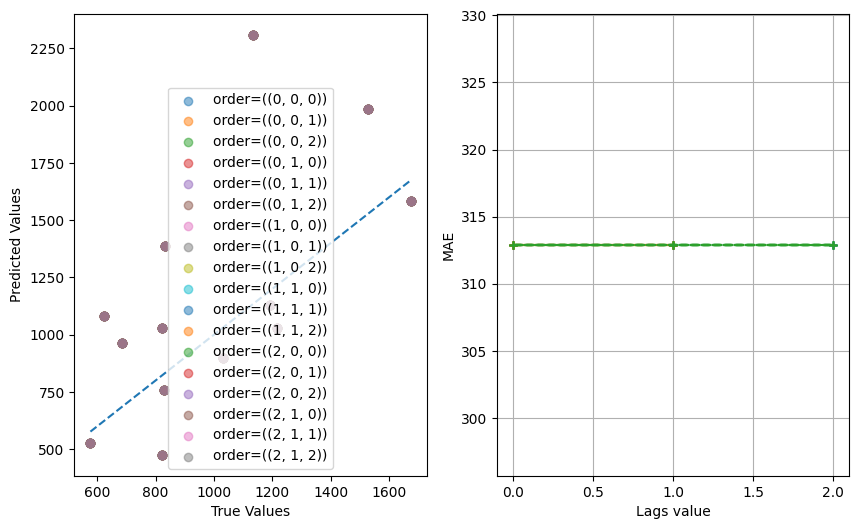

time: 1.21 s (started: 2024-04-11 16:41:44 +02:00)


In [27]:
from windml.machine_learning.time_analysis import ar_forecast
from itertools import product

fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Define the range of parameters to test
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

mae_list = []
order_list = []
for p, d, q in product(p_values, d_values, q_values):
    order = (p, d, q)
    try:
        forecast_df = ar_forecast(monthly_df, 'E_avg', lags=lags)
        merged_df = pd.merge(monthly_df, forecast_df, on=['Year', 'Month'], how='inner')
        mae = mean_absolute_error(merged_df['E_avg'], merged_df['pred_E_avg'])
        mae_list.append(mae)
        order_list.append((p, d, q))
        ax[0].scatter(merged_df['E_avg'], merged_df['pred_E_avg'], alpha=0.5, label=f'order={order}')
        print(f"Mean Absolute Error (MAE): {mae}")
    except:
        print(f'ARIMA{order} failed to converge')


    
ax[0].set_xlabel('True Values')
ax[0].set_ylabel('Predicted Values')
ax[0].legend()

xx = np.linspace(merged_df['E_avg'].min(),merged_df['E_avg'].max())
ax[0].plot(xx, xx, ls='--')

ax[1].plot(order_list, mae_list, '+', ls = '--')
ax[1].set_xlabel('Lags value')
ax[1].set_ylabel('MAE')

plt.grid(True)
plt.show()


## Comment

It is important to note that ```statsmodels``` is not directly compatible with ```scikit-learn```'s pipeline structure (eg ```Pipeline``` and ```GridSearchCV```), since it does not implement the ```fit``` and ```predict``` methods in the way scikit-learn expects.

One can create a custom wrapper for the ARIMA model that adheres to scikit-learn's interface, and then use GridSearchCV or similar tools for parameter tuning.